In [3]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import os

data_path = './data-files/'
for file in os.listdir(data_path):
	if 'csv' in file and 'zip' not in file:
		print(file.ljust(30) + str(round(os.path.getsize(data_path + file) / (1000 * 1000), 2)) + 'MB')


sample_submission.csv         0.02MB
test.csv                      0.42MB
train.csv                     0.99MB


In [6]:
train = pd.read_csv('./data-files/train.csv')
test = pd.read_csv('./data-files/test.csv')
train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


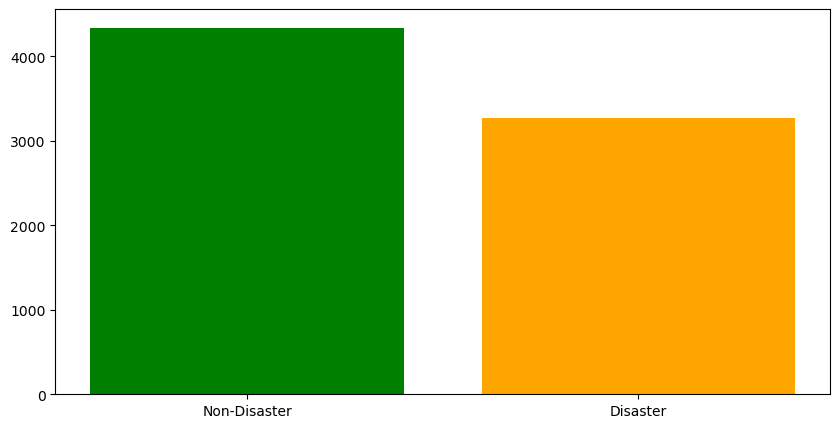

In [8]:
# EDA

news_class = train['target'].value_counts()
labels = ['Non-Disaster', 'Disaster']

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels, news_class, color=['green', 'orange'])

plt.show()

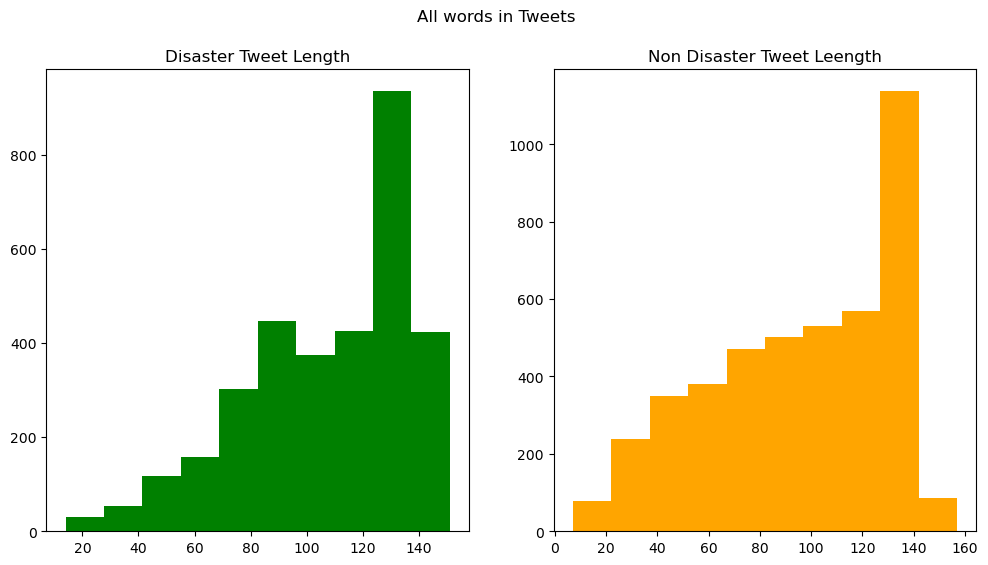

In [9]:
disaster_tweet_len = train[train['target'] == 1]['text'].str.len()
non_disaster_tweet_len = train[train['target'] == 0]['text'].str.len()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(disaster_tweet_len, color='green')
ax[0].set_title('Disaster Tweet Length')

ax[1].hist(non_disaster_tweet_len, color='orange')
ax[1].set_title('Non Disaster Tweet Leength')

fig.suptitle('All words in Tweets')
plt.show()

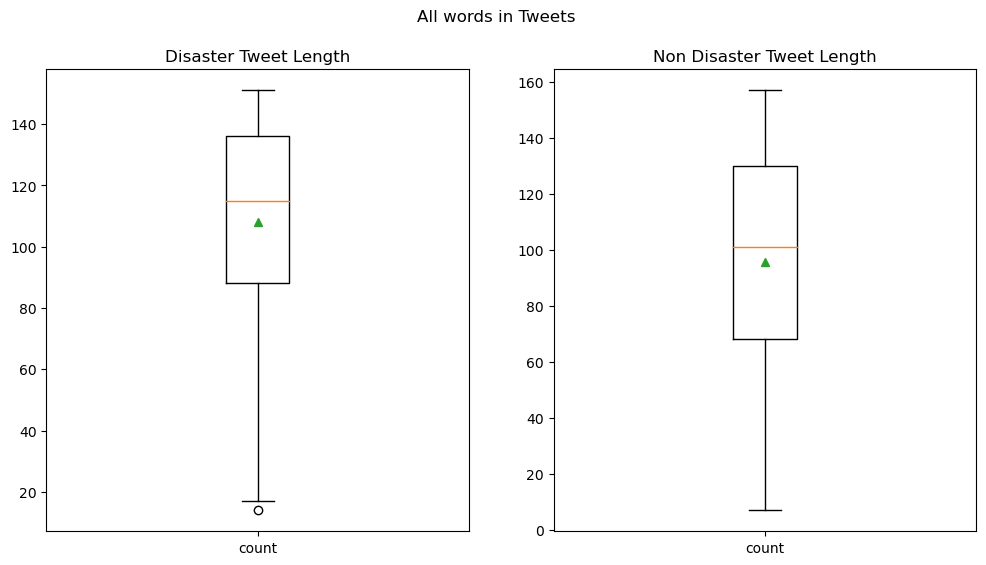

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].boxplot(disaster_tweet_len, labels=['count'], showmeans=True)
ax[0].set_title('Disaster Tweet Length')
ax[1].boxplot(non_disaster_tweet_len, labels=['count'], showmeans=True)
ax[1].set_title('Non Disaster Tweet Length')
fig.suptitle('All words in Tweets')
plt.show()

In [11]:
disaster_tweet_len.describe(), non_disaster_tweet_len.describe()

(count    3271.000000
 mean      108.113421
 std        29.309854
 min        14.000000
 25%        88.000000
 50%       115.000000
 75%       136.000000
 max       151.000000
 Name: text, dtype: float64,
 count    4342.000000
 mean       95.706817
 std        35.885924
 min         7.000000
 25%        68.000000
 50%       101.000000
 75%       130.000000
 max       157.000000
 Name: text, dtype: float64)

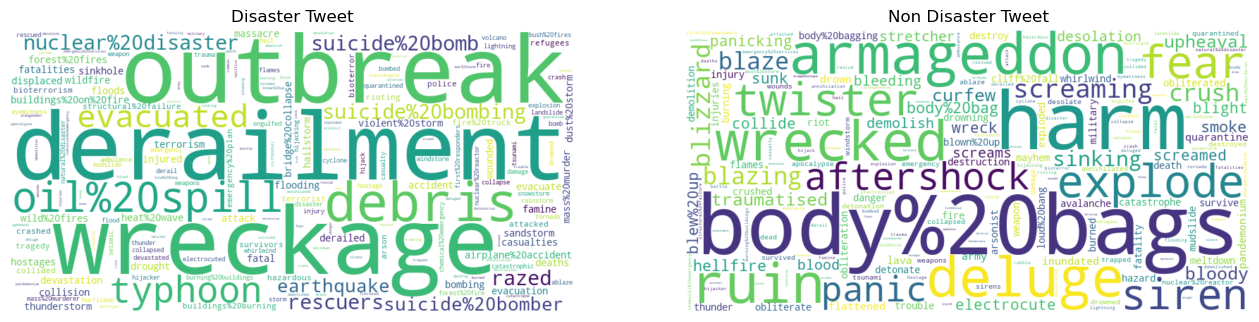

In [12]:
from wordcloud import WordCloud, STOPWORDS

disaster_tweet_keywords = dict(train[train['target'] == 1]['keyword'].value_counts())
non_disaster_tweet_keywords =  dict(train[train['target'] == 0]['keyword'].value_counts())

stopwords = set(STOPWORDS)
disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
	generate_from_frequencies(disaster_tweet_keywords)
non_disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
	generate_from_frequencies(non_disaster_tweet_keywords)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweet')
ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non Disaster Tweet')
plt.show()

결측치 데이터 컬럼과 건수:
           Missing Ratio Data Type
location      33.272035    object
keyword        0.801261    object
결측치 데이터 컬럼과 건수:
           Missing Ratio Data Type
location      33.864542    object
keyword        0.796813    object


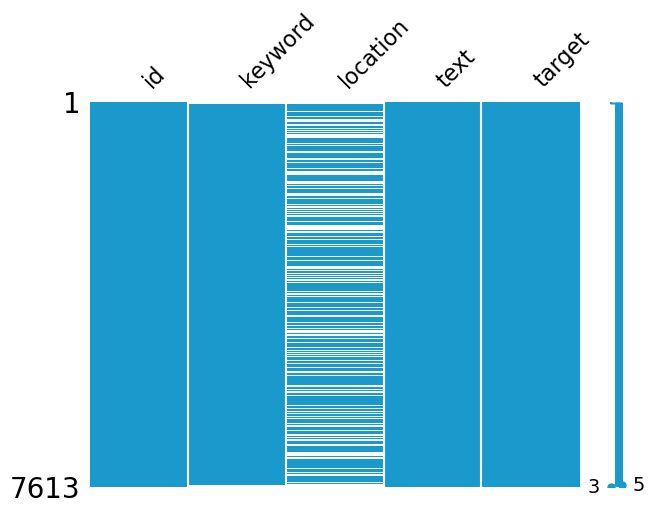

In [13]:
#피쳐 엔지니어링
import missingno as msno

def check_na(data, head_num=6):
	isnull_na = (data.isnull().sum() / len(data)) * 100
	data_na = isnull_na.drop(isnull_na[isnull_na == 0].index).sort_values(ascending = False)
	missing_data = pd.DataFrame({'Missing Ratio' : data_na,
								'Data Type' : data.dtypes[data_na.index]})
	print('결측치 데이터 컬럼과 건수:\n', missing_data.head(head_num))	

check_na(train)
check_na(test)
msno.matrix(df=train.iloc[:, :], color=(0.1, 0.6, 0.8), figsize=(7,5))
plt.show()

In [35]:
test_id = test['id']
for datas in [train, test]:
	datas = datas.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

train.shape, test.shape

((7613, 3), (3263, 2))

In [36]:
import string
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

def data_cleansing(text, remove_stopwords=False):
	
	#remove url
	# http 또는 https로 시작하고 // 이후 화이트스페이스가 아닌 문자(1개 이상) 또는(|)
	# www. 이후 화이트스페이스가 아닌 문자(1개 이상)을 표현하는 정규식
	url = re.compile(r'https?://\S+|www\.\S+') 
	cleaned_text = url.sub(r'', text) # 다른 문자로 대체하는 함수

	#remove html
	html = re.compile(r'<.*?>') # <로 시작하고 모든 문자 0번 이상 반복 및 >로 끝나는 문자열, *? : 더 적은 횟수를 선호
	cleaned_text = html.sub(r'', text)

	#remove emoji
	emoji_pattern = re.compile("["
							u"\U0001F600-\U0001F64F" #emoticons
							u"\U0001F300-\U0001F5FF" #symbols & pictographs
							u"\U0001F680-\U0001F6FF" #transport & map symbols
							u"\U0001F1E0-\U0001F1FF" #flags (IOS)
							u"\U00002702-\U000027B0"
							u"\U000024C2-\U0001F251"
							"]", flags=re.UNICODE)
	cleaned_text = emoji_pattern.sub(r'', text)

	#Special Letters to empty space
	cleaned_text = re.sub("[^a-zA-Z]", "", cleaned_text)

	#Remove Punctuation
	table = str.maketrans('', '', string.punctuation)
	cleaned_text = cleaned_text.translate(table)

	#Lowercase
	cleaned_text = cleaned_text.lower().split()

	if remove_stopwords:
		stops = set(stopwords.words('english'))
		cleaned_text = [word for word in cleaned_text if not word in stops]
		clean_review = ' '.join(cleaned_text)
	else:
		clean_review = ' '.join(cleaned_text)
	
	return clean_review

clean_train_review = []
for datas in [train, test]:
	datas['cleaned_text'] = datas['text'].apply(lambda x: data_cleansing(x, remove_stopwords=True))

train.head()

,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,ourdeedsarethereasonofthisearthquakemayallahfo...
1,Forest fire near La Ronge Sask. Canada,1,forestfirenearlarongesaskcanada
2,All residents asked to 'shelter in place' are ...,1,allresidentsaskedtoshelterinplacearebeingnotif...
3,"13,000 people receive #wildfires evacuation or...",1,peoplereceivewildfiresevacuationordersincalifo...
4,Just got sent this photo from Ruby #Alaska as ...,1,justgotsentthisphotofromrubyalaskaassmokefromw...


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char', sublinear_tf=True
							 ,ngram_range=(1, 3), max_features=10000)
X = np.asarray(vectorizer.fit_transform(train['cleaned_text']).todense())
y = train['target'].values
X.shape, y.shape

((7613, 10000), (7613,))

In [43]:
#modelling
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5329, 10000), (2284, 10000), (5329,), (2284,))

In [44]:
#logistic
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(class_weight='balanced') # 비대칭 데이터 반영한 가중치
lgs.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [50]:
X_testset  = np.asarray(vectorizer.transform(test['cleaned_text']).todense())
print("The Shape of Test Dataset:", X_testset.shape)

y_test_pred = lgs.predict(X_testset)
print("The Predict Value:", y_test_pred)
y_test_pred = np.where(y_test_pred >= 0.5, 1, 0)
print("The Predict Class:", y_test_pred)

submission_file = pd.DataFrame({'id' : test_id
								,'target' : y_test_pred
								})
print(submission_file.head())

submission_file.to_csv('submission_lgs_20231201.csv', index=False)

The Shape of Test Dataset: (3263, 10000)
The Predict Value: [0 0 1 ... 1 1 1]
The Predict Class: [0 0 1 ... 1 1 1]
   id  target
0   0       0
1   2       0
2   3       1
3   9       1
4  11       1
